In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
"""Joins a spatiotemporal world with a chained lawnmower trajectory.

Example parameters can be modified at the start of the file.

Example usage (within the fumes environment):
    python fumes/examples/traj_chaining_bullseye.py
"""

import numpy as np
import matplotlib.pyplot as plt

from fumes.environment import Bullseye
from fumes.environment.utils import xcoord_circle, ycoord_circle

from fumes.trajectory import Lawnmower, Spiral
from fumes.planner import TrajectoryOpt, TrajectoryChain, \
    LawnSpiralGeneratorFlexible, LawnSpiralWithStartGeneratorFlexible, \
    LawnSpiralGenerator

from fumes.model import FullyObs
from fumes.robot import OfflineRobot
from fumes.simulator import Simulator

from fumes.reward import SampleValues

from fumes.environment import Extent
from fumes.utils import tic, toc

import pdb

In [16]:
# Parameters
experiment_name = "flexible_traj_opt_chain"

# Trajectory params
traj_type = "lawnmower"  # type of fixed trajectory
resolution = 5  # lawnmower resolution (in meters)
time_resolution = 3600  # time resolution (in seconds)

# Environment params
nx = 500  # environment x width (in meters)
ny = 500  # environment y height (in meters)

# Simulation params
t0 = 0.0  # initial time
duration = 12 * 3600.  # duration (in seconds)

# Robot params
vel = 0.5  # robot velocity (in meters/second)
samp_dist = 0.5  # distance between samples (in meters)
com_window = 120  # communication window (in seconds)
altitude = 0.0

In [17]:
# Create the environment
extent = Extent(xrange=(0., 500.), xres=100, yrange=(0., 500.), yres=100)
environment = Bullseye(extent, xcoord_circle, ycoord_circle, l=0.01, A=1.0)

# Create a fully observeable model
model = FullyObs(extent, environment)

# Reward function
reward = SampleValues(
    sampling_params={"samp_dist": samp_dist},
    is_cost=True)


planners = []
budget = time_resolution * vel  # distance budget per leg
for start_time in np.arange(0, duration, step=time_resolution):
    # Create the base trajectory generator object with a temporary start_point
    # We will reset this later in the chaining process.
    traj_generator = LawnSpiralWithStartGeneratorFlexible(
        t0=start_time, vel=vel, alt=altitude, start_point=(0., 0.), 
        traj_type=traj_type, res=resolution)

    # Get predicted environment maxima
    xm, ym = model.get_maxima(start_time)
    
    # Create planner
    planners.append(TrajectoryOpt(
        model,
        traj_generator,
        reward,
        x0=(75., 75., 0., xm, ym),  # (lh, lw, rot, origin_x, origin_y)
        param_bounds=[(20., 100), (20., 100.), (-360., 360.), (0., 500.), (0., 500.)],        
        param_names={"lh": 0, "lw": 1, "rot": 2, "origin_x": 3, "origin_y": 4},        
        budget=budget,
        limits=[0., 500., 0., 500.],
        max_iters=3
    ))

planner = TrajectoryChain(planners=planners)

In [18]:
##################################################
# Get trajectory to execute
##################################################
print("Getting trajectory...")
tic()
plan_opt = planner.get_plan()
toc()

Getting trajectory...
Planning chain 0 of 12 at time 0.0
Adding budget constraint.
Adding safety boundary constraint.
Adding parameter bounds constraint.
n:1
n:2
n:3
The maximum number of function evaluations is exceeded.
Number of iterations: 3, function evaluations: 18, CG iterations: 2, optimality: 7.93e+04, constraint violation: 0.00e+00, execution time:  5.8 s.
Optimization completed. Result: [ 75.  75.   0. 400. 300.]
Length: 1775.0
	Planned parameters (lh, lw, orientation, origin_x, origin_y): 75.0 75.0 0.0 400.0 300.0
-elapsed time: 8.89 (s)
Planning chain 1 of 12 at time 3550.0
Adding budget constraint.
Adding safety boundary constraint.
Adding parameter bounds constraint.
Added soft origin constraint.
Added a diversity incentive.
n:1
n:2
n:3
The maximum number of function evaluations is exceeded.
Number of iterations: 3, function evaluations: 18, CG iterations: 2, optimality: 8.05e+04, constraint violation: 0.00e+00, execution time:  6.0 s.
Optimization completed. Result: [ 7

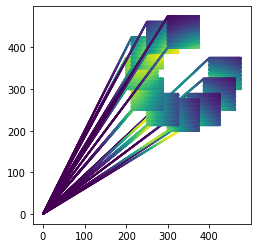

In [19]:
# Create the robot
rob = OfflineRobot(model, plan_opt, environment, vel, com_window)

# Create the simulator
simulator = Simulator(rob, environment)

# Run the simulator
times = np.arange(0, duration + 1)
simulator.simulate(times, experiment_name=experiment_name)

# Plot outcomes
simulator.plot_comms()
simulator.plot_all()

Generating global simulation.
-elapsed time: 1.27e+03 (s)


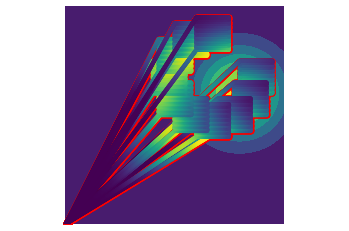

In [20]:
simulator.plot_world()